# Progress report 2022-06-20
Daniel Mishler

- Someone push my patch to github?
- question: you can run things like jupyter on other machines?

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import parsec_animation_utils as panimate

In [3]:
from matplotlib.animation import FuncAnimation
from IPython import display
plt.ioff()

## Tilesize investigation

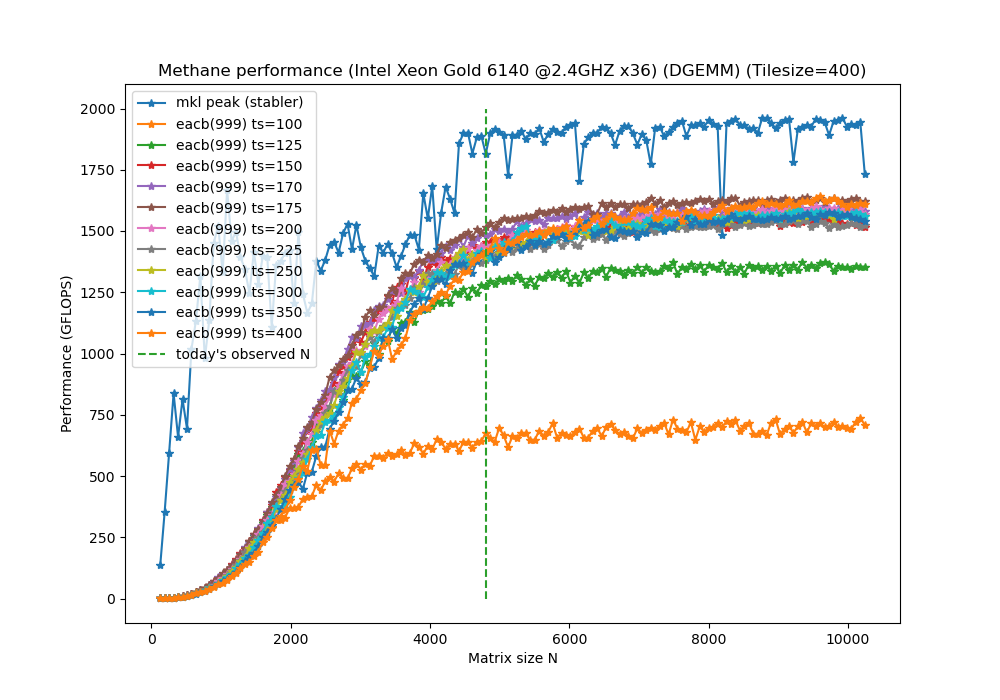

In [4]:
dgemm_methane_peak_stable = pd.read_csv("2022-06-14_36_core_peak_test.csv")
plt.ioff()
tilesizes = [100, 125, 150, 170, 175, 200, 225, 250, 300, 350, 400]
dgemm_methane_eacb_999 = {}

plt.figure(figsize = [10,7])
for tilesize in tilesizes:
    dgemm_methane_eacb_999[tilesize] = pd.read_csv("2022-06-14_eacb999_ts%d_rectangle.csv"% tilesize)

plt.plot(dgemm_methane_peak_stable["N"],    dgemm_methane_peak_stable["GFLOPS"],    "*-", label = "mkl peak (stabler)")
for tilesize in tilesizes:
    plt.plot(dgemm_methane_eacb_999[tilesize]["N"],
             dgemm_methane_eacb_999[tilesize]["GFLOPS"],
             "*-", label = "eacb(999) ts=%d" % tilesize)
plt.plot([4800,4800], [0,2000], "--", label="today's observed N")

plt.title("Methane performance (Intel Xeon Gold 6140 @2.4GHZ x36) (DGEMM) (Tilesize=%03d)"%tilesize)
plt.legend()
plt.xlabel("Matrix size N")
plt.ylabel("Performance (GFLOPS)")
fname = '2022-06-14_methane_trace_performance_investigation'
plt.savefig(fname + '.svg')
plt.savefig(fname + '.pdf')
plt.savefig(fname + '.png')
display.Image(fname+'.png')

In [5]:
dgemm_mkl_peak = max(dgemm_methane_peak_stable["GFLOPS"])
tilesizemax = []
for tilesize in tilesizes:
    tilesizemax.append(max(dgemm_methane_eacb_999[tilesize]["GFLOPS"]))
dgemm_dplasma_peak = max(tilesizemax)
print(dgemm_dplasma_peak/dgemm_mkl_peak)

0.8383764351260343


## Trace testing

In [6]:
trace_potrf    = pd.HDFStore("2022-06-15_mid_dpotrf.prof.h5")
trace_eacb144  = pd.HDFStore("eacb144_profile.prof.h5")
trace_omritest = pd.HDFStore("dpotrf_tlr.2.90000.3600.2x2.mvapich2.13358284.h5")

In [7]:
panimate.animate_trace(trace_potrf,
                     "ptg",
                     "potrf",
                     which_animate = "progress",
                     title="potrf trace testing",
                     num_frames = 30,
                     fps = 10,
                     N = 5400,
                     M = 5400,
                     K = 5400,
                     tilesize = 180)

Beginning animation of data 'potrf trace testing' method 'progress'
found task type potrf_dgemm
found task type potrf_dsyrk
found task type potrf_dtrsm
found task type potrf_dpotrf
process runtime per frame: 0.002300 seconds
estimated execution time (assuming a lightweight commercial processor): 10.800000 seconds
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here

m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (syrk)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (trsm)
m should not be none here (syrk)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (syrk)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (syrk)
m should not be none here (trsm)
m should n

m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (trsm)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should n

m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (syrk)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (trsm)
m should not be none here (syrk)
m should n

Data titled 'potrf trace testing'
M=5400,	N=5400,	K=5400,	tilesize=180
average task execution time: 0.331854
task execution time standard deviation: 0.494324
utilization: 23.851412 over 36 cores (0.662539)
execution time to generate graphs: 6.840983 seconds
saved task metadata file: tasks_per_frame_(potrf trace testing).png
saved task metadata file: tasks_times_execution_order_(potrf trace testing).png
saved task metadata file: tasks_times_sorted_(potrf trace testing).png



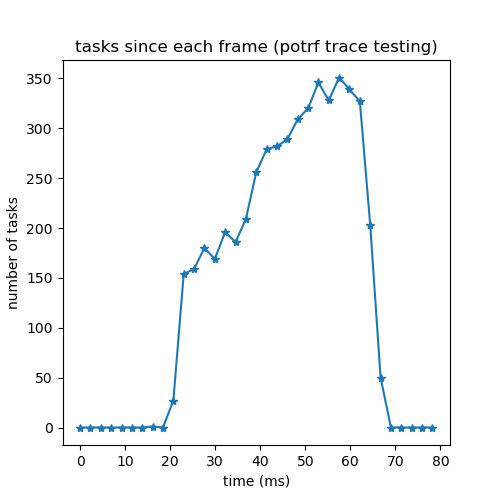

In [8]:
display.Image("tasks_per_frame_(potrf trace testing).png")

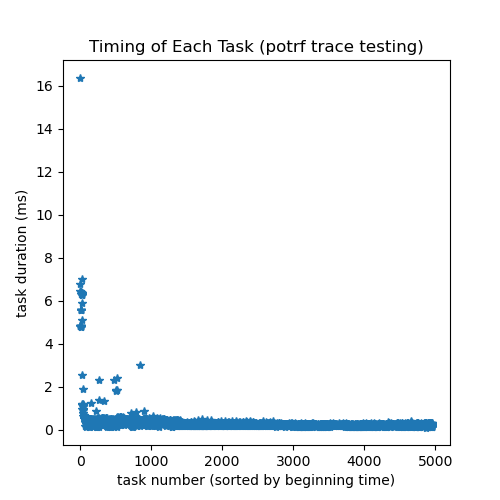

In [9]:
display.Image("tasks_times_execution_order_(potrf trace testing).png")

In [10]:
panimate.animate_trace(trace_omritest,
                     "ptg",
                     "potrf",
                     which_animate = "progress",
                     title="potrf tiled trace testing",
                     num_frames = 50,
                     fps = 14,
                     N = 90000,
                     M = 90000,
                     K = 90000,
                     tilesize = 3600)

Beginning animation of data 'potrf tiled trace testing' method 'progress'
found task type hicma_dpotrf_l_3flow::potrf_dgemm
found task type hicma_dpotrf_l_3flow::potrf_dsyrk
found task type hicma_dpotrf_l_3flow::potrf_dtrsm
found task type hicma_dpotrf_l_3flow::potrf_dpotrf
process runtime per frame: 0.063622 seconds
estimated execution time (assuming a lightweight commercial processor): 12.500000 seconds


Data titled 'potrf tiled trace testing'
M=90000,	N=90000,	K=90000,	tilesize=3600
average task execution time: 19.373045
task execution time standard deviation: 14.500053
utilization: 17.813514 over 127 cores (0.140264)
execution time to generate graphs: 17.774664 seconds
saved task metadata file: tasks_per_frame_(potrf tiled trace testing).png
saved task metadata file: tasks_times_execution_order_(potrf tiled trace testing).png
saved task metadata file: tasks_times_sorted_(potrf tiled trace testing).png



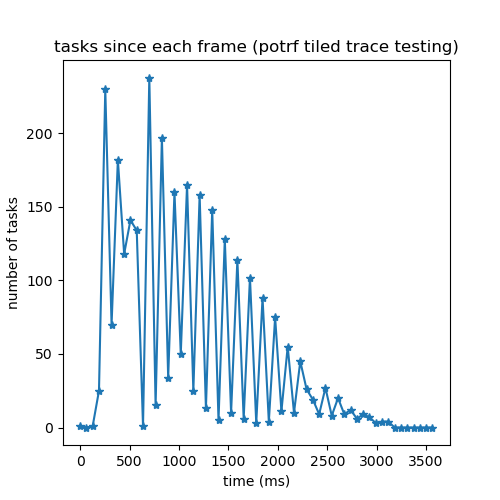

In [11]:
display.Image("tasks_per_frame_(potrf tiled trace testing).png")

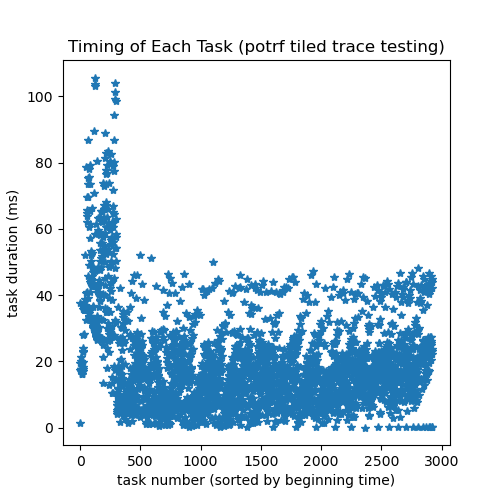

In [12]:
display.Image("tasks_times_execution_order_(potrf tiled trace testing).png")

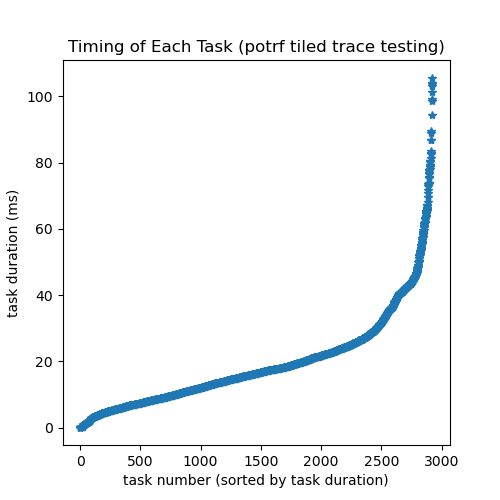

In [13]:
display.Image("tasks_times_sorted_(potrf tiled trace testing).png")

In [14]:
panimate.animate_trace(trace_eacb144,
                     "dtd",
                     "gemm",
                     panimate.rectangle_order_generator_improved,
                     which_animate = "abcprogress",
                     title="enforced rectangle eacb 144",
                     num_frames = 30,
                     fps = 10,
                     N = 4800,
                     M = 4800,
                     K = 4800)

Beginning animation of data 'enforced rectangle eacb 144' method 'abcprogress'
process runtime per frame: 0.005354 seconds
estimated execution time (assuming a lightweight commercial processor): 20.736000 seconds


Data titled 'enforced rectangle eacb 144'
M=4800,	N=4800,	K=4800,	tilesize=200
average task execution time: 0.390608
task execution time standard deviation: 0.581035
utilization: 33.616802 over 36 cores (0.933800)
execution time to generate graphs: 20.755188 seconds
saved task metadata file: tasks_per_frame_(enforced rectangle eacb 144).png
saved task metadata file: tasks_times_execution_order_(enforced rectangle eacb 144).png
saved task metadata file: tasks_times_sorted_(enforced rectangle eacb 144).png



In [15]:
testArr = np.array([[1,2],[3,4]])

In [16]:
testArr

array([[1, 2],
       [3, 4]])

In [17]:
"hello" in "hellowworld"

True